In [30]:
import pandas as pd
import numpy as np
import sklearn
import os
from os.path import join

In [31]:
#DATA Load

pd_train = pd.read_csv('C:/Users/user/audio_to_emotion/train.csv')
pd_test = pd.read_csv('C:/Users/user/audio_to_emotion/test.csv')

print(pd_train.info(), pd_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         630 non-null    int64 
 1   file_name  630 non-null    object
 2   emotion    630 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         210 non-null    int64 
 1   file_name  210 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.4+ KB
None None


### Data Preprocessing

In [32]:
import librosa
import glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import librosa, librosa.display 

def load_audiofiles(file_name, sample_rate=48000):
    
    result=np.array([])
    
    audio_signal, sample_rate = librosa.load(file_name, duration=3, offset=0.5, sr=sample_rate)

    signal = np.zeros(int(sample_rate*3,))
    signal[:len(audio_signal)] = audio_signal
    
    return signal
    

### wav -> windowing & sampling

In [33]:
# DataFlair - Load the data and extract features for each sound file
from tqdm import tqdm
def load_data(data_info, isTrain=True):
    
    if isTrain:
        train_data = [] # dictionary for audio feature
        train_label = [] # labellist for training list
        
        file_list = data_info['file_name']
        emotion_list = data_info['emotion']
        for file_name, emotion in tqdm(zip(file_list, emotion_list)):
            
            hi=join('audio_dataset/train_dataset',file_name)
            train_data.append(load_audiofiles(hi))
            train_label.append(emotion)
            
        return np.array(train_data), np.array(train_label)
    
    else:
        test_data = []
        file_list = data_info['file_name']
    
        for file_name in tqdm(file_list):

            hi=join('audio_dataset/test_dataset',file_name)
            test_data.append(load_audiofiles(hi))
            
        return np.array(test_data)

# DataFlair - Split the dataset
train_data, train_label = load_data(pd_train)
test_data = load_data(pd_test, isTrain=False)

630it [00:00, 686.29it/s]
100%|██████████| 210/210 [00:00<00:00, 706.57it/s]


### Vectorization

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_label)
y_train = le.transform(train_label)

### Audio_feature to Mel_spectrogram using Fourier transform & mel filter

In [35]:
def Calculate_Melspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

mel_train = []
print("Calculate mel spectrograms for train set")
train_data = np.stack(np.array(train_data),0)
test_data = np.stack(np.array(test_data),0)
for i in range(train_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(train_data[i,:], sample_rate=48000)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,train_data.shape[0]),end='')
    
print('')
mel_train = np.stack(mel_train,axis=0)

mel_test = []
for i in range(test_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(test_data[i,:], sample_rate=48000)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,test_data.shape[0]),end='')
    
print('')
mel_test = np.stack(mel_test,axis=0)

print(f'mel_train:{mel_train.shape}, mel_test:{mel_test.shape}')

Calculate mel spectrograms for train set
 Processed 630/630 files
 Processed 210/210 files
mel_train:(630, 128, 563), mel_test:(210, 128, 563)


### Scale normaliztaion with mel_spectrogram

In [36]:
from sklearn.preprocessing import StandardScaler

x_train = np.expand_dims(mel_train, 1) #DataNum, 1ch, H, W
x_test = np.expand_dims(mel_test, 1)

scaler = StandardScaler()

b,c,h,w = x_train.shape
x_train = np.reshape(x_train, newshape=(b,-1))
x_train = scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(b,c,h,w))

b,c,h,w = x_test.shape
x_test = np.reshape(x_test, newshape=(b,-1))
x_test = scaler.transform(x_test)
x_test = np.reshape(x_test, newshape=(b,c,h,w))

### Model Pipeline
![Alt text](model_pipeline.png)
### Details
![Alt text](details.png)

In [37]:
import torch
import torch.nn as nn

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()

            # 1. conv block
        self.relu = nn.ReLU()
        self.conv1= nn.Conv2d(in_channels=1,
                   out_channels=16,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn1 = nn.BatchNorm2d(16)

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do = nn.Dropout2d(p=0.3)
        # 2. conv block
        self.conv2= nn.Conv2d(in_channels=16,
                   out_channels=32,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn2 = nn.BatchNorm2d(32)
        self.mp2 = nn.MaxPool2d(kernel_size=4, stride=4)

        # 3. conv block
        self.conv3 = nn.Conv2d(in_channels=32,
                   out_channels=64,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn3 = nn.BatchNorm2d(64)

        # 4. conv block
        self.conv4= nn.Conv2d(in_channels=64,
                   out_channels=128,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn4= nn.BatchNorm2d(128)

        # Linear softmax layer
        self.out_linear = nn.Linear(512,num_emotions)
        self.out_softmax = nn.Softmax(dim=1)
        
    def forward(self,x):

        # transformer embedding
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.do(self.mp1(out))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn4(self.conv4(out)))
        out = self.do(self.mp2(out))


        conv_embedding = torch.flatten(out, start_dim=1)

        output_logits = self.out_linear(conv_embedding)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax  
    
model = ParallelModel(num_emotions=8).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

cuda
Number of trainable params:  101736


### Hyperparameter optimization

In [38]:
EPOCHS=150
DATASET_SIZE = x_train.shape[0]
BATCH_SIZE = 64

## Baseline : optimizer - SGD, learning rate = 0.01, momentum=0.9
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [39]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

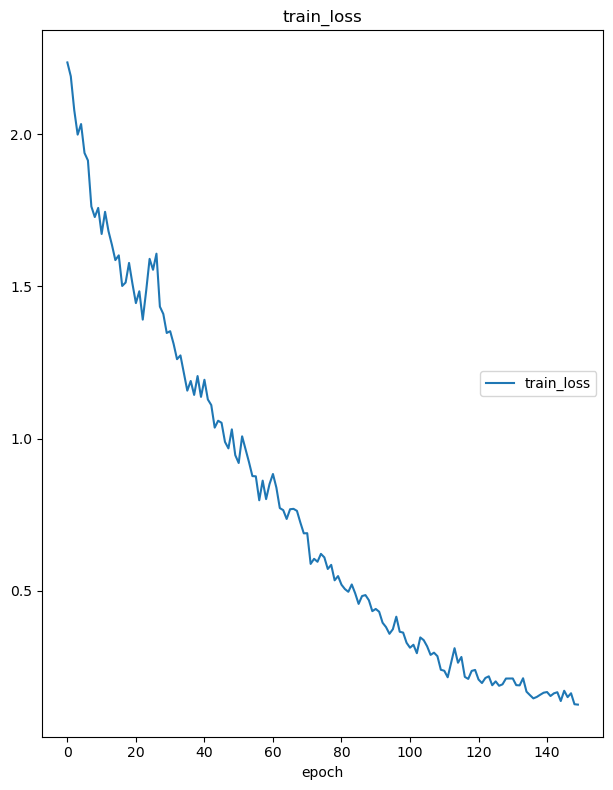

train_loss
	train_loss       	 (min:    0.126, max:    2.235, cur:    0.126)


In [40]:
# !pip install livelossplot
from livelossplot import PlotLosses
liveloss = PlotLosses()

logs = {}

model.train()

for epoch in range(EPOCHS):
    # shuffle data
    ind = np.random.permutation(DATASET_SIZE)

    x_train = x_train[ind,:,:,:]
    y_train = y_train[ind]
    
    epoch_loss = 0
    
    iters = int(DATASET_SIZE / BATCH_SIZE)
     
    for i in range(iters):
        ### indexing
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        
        x = x_train[batch_start:batch_end,:,:,:]
        y = y_train[batch_start:batch_end]
        
 
        x_tensor = torch.tensor(x,device=device).float()
        y_tensor = torch.tensor(y, dtype=torch.long, device=device)
        
        # forward pass
        output_logits, output_softmax = model(x_tensor)

        # compute loss
        loss = loss_fnc(output_logits, y_tensor)
        
        # compute gradients
        OPTIMIZER.zero_grad()
        loss.backward()
        # update parameters
        OPTIMIZER.step()

        epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE

    logs['train_loss'] = epoch_loss
    if epoch % 10 == 0:
    print('Epoch: ', epoch, 'loss: ', epoch_loss)
        
    liveloss.update(logs)
    liveloss.draw()

### Evaluation

In [41]:
model.eval()

predicts = []

with torch.no_grad():
    for data in tqdm(x_test):
        data = torch.FloatTensor(data).to(device).unsqueeze(1)

        _ , output_softmax = model(data)
        predictions = torch.argmax(output_softmax,dim=1).cpu().numpy()
        predicts.append(predictions)

print(f'predict_len:{len(predicts)}')

100%|██████████| 210/210 [00:00<00:00, 855.94it/s]

predict_len:210


In [43]:
### Result
inv_predicts = le.inverse_transform(predicts)
inv_predicts

c:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['disgust', 'disgust', 'surprised', 'angry', 'sad', 'surprised',
       'fearful', 'happy', 'calm', 'surprised', 'fearful', 'calm',
       'disgust', 'calm', 'neutral', 'fearful', 'surprised', 'calm',
       'calm', 'fearful', 'calm', 'surprised', 'sad', 'angry', 'calm',
       'angry', 'surprised', 'angry', 'calm', 'sad', 'neutral', 'sad',
       'angry', 'disgust', 'fearful', 'disgust', 'sad', 'sad', 'neutral',
       'disgust', 'fearful', 'calm', 'calm', 'angry', 'angry', 'angry',
       'sad', 'happy', 'calm', 'angry', 'calm', 'happy', 'calm', 'happy',
       'disgust', 'angry', 'happy', 'fearful', 'angry', 'neutral',
       'angry', 'neutral', 'calm', 'happy', 'happy', 'neutral',
       'surprised', 'happy', 'calm', 'disgust', 'surprised', 'surprised',
       'happy', 'angry', 'surprised', 'angry', 'fearful', 'surprised',
       'fearful', 'neutral', 'calm', 'angry', 'happy', 'calm', 'disgust',
       'angry', 'disgust', 'fearful', 'angry', 'disgust', 'surprised',
       'di

### Save

In [44]:
ID = np.array([i for i in range(len(inv_predicts))]).reshape(-1,1)

results = np.hstack([ID, np.array(inv_predicts).reshape(-1,1)])

results =pd.DataFrame(results, columns=['ID','emotion'])
results.to_csv("baseline.csv", index=False)